# Time Series Prediction

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
import json

In [106]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [107]:
# Load the dataset
with open('database.json') as json_database:
    database = json.load(json_database)

# Concat data from sector economy
X_eco_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'economy':
        new_data = pd.read_json(database[i]['data'])
        if X_eco_raw is None:
            X_eco_raw = new_data
        else:
            X_eco_raw = pd.concat([X_eco_raw, new_data], axis=1, join="inner")

dataset = X_eco_raw.values
dataset = dataset.astype('float64')
print(dataset.shape)

# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train= dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]

# Reshape dataset
look_back = 3
trainX = np.zeros((dataset.shape[1], len(train)-look_back-1, look_back))
trainY = np.zeros((dataset.shape[1], len(train)-look_back-1))
testX = np.zeros((dataset.shape[1], len(test)-look_back-1, look_back))
testY = np.zeros((dataset.shape[1], len(test)-look_back-1))
for i in range(dataset.shape[1]):
    trainX[i, :], trainY[i, :] = create_dataset(train[:, i], look_back)
    testX[i, :], testY[i, :] = create_dataset(test[:, i], look_back)
X_eco_raw.head()

(183, 9)


,ECO_Consumer_Price_Index,ECO_Unemployment_Number,ECO_DAX,ECO_MDAX,ECO_Wholesale_Turnover,ECO_Retail_Sales,ECO_Accommodation,ECO_Hotels_Inns_Guesthouses,ECO_Gastronomy
2005-01-01,85.3,5086847,4246.440011,5506.678548,83.5,87.7,79.3,77.7,104.5
2005-02-01,85.6,5288245,4344.744019,5737.214453,85.0,83.9,80.5,80.4,99.8
2005-03-01,86.0,5266085,4357.401460,5696.047894,98.1,98.3,90.5,89.4,112.1
2005-04-01,85.8,5052429,4293.807617,5708.181431,96.3,97.8,99.4,99.0,116.0
2005-05-01,85.9,4884238,4329.549139,5751.507302,94.6,94.3,112.7,111.5,122.9


## Multilayer Perceptron Regression

In [108]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan

for i in range(dataset.shape[1]):
    model = Sequential()
    model.add(Dense(12, input_dim=look_back, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX[i], trainY[i], epochs=400, batch_size=2, verbose=2)
    # Estimate model performance
    trainScore = model.evaluate(trainX[i], trainY[i], verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(testX[i], testY[i], verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

    # Generate predictions for training
    trainPredict = model.predict(trainX[i])
    testPredict = model.predict(testX[i])

    # Shift train predictions for plotting
    trainPredictPlot[look_back:len(trainPredict)+look_back, i] = trainPredict[:, 0]
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, i] = testPredict[:, 0]

Streaming output truncated to the last 5000 lines.
 - 0s - loss: 112944.5979
Epoch 309/400
 - 0s - loss: 108249.6123
Epoch 310/400
 - 0s - loss: 109255.7474
Epoch 311/400
 - 0s - loss: 114183.1589
Epoch 312/400
 - 0s - loss: 111472.7368
Epoch 313/400
 - 0s - loss: 116867.2854
Epoch 314/400
 - 0s - loss: 121233.3490
Epoch 315/400
 - 0s - loss: 112532.1167
Epoch 316/400
 - 0s - loss: 111017.7282
Epoch 317/400
 - 0s - loss: 115523.5157
Epoch 318/400
 - 0s - loss: 107473.8060
Epoch 319/400
 - 0s - loss: 108273.6514
Epoch 320/400
 - 0s - loss: 103890.9725
Epoch 321/400
 - 0s - loss: 113140.9462
Epoch 322/400
 - 0s - loss: 103358.3800
Epoch 323/400
 - 0s - loss: 109235.7672
Epoch 324/400
 - 0s - loss: 103490.9169
Epoch 325/400
 - 0s - loss: 114971.8539
Epoch 326/400
 - 0s - loss: 110727.3369
Epoch 327/400
 - 0s - loss: 112588.8245
Epoch 328/400
 - 0s - loss: 121357.9621
Epoch 329/400
 - 0s - loss: 115580.7286
Epoch 330/400
 - 0s - loss: 115779.4233
Epoch 331/400
 - 0s - loss: 109322.7048
Epo

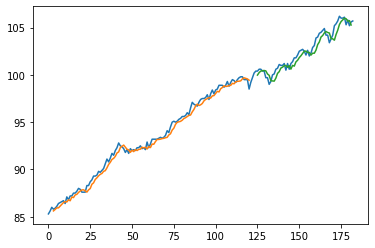

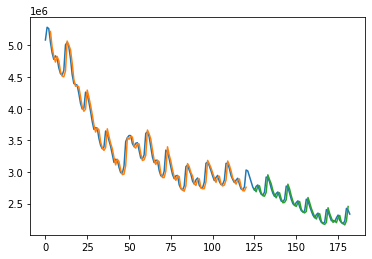

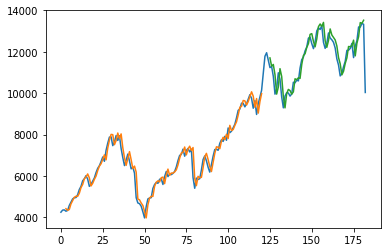

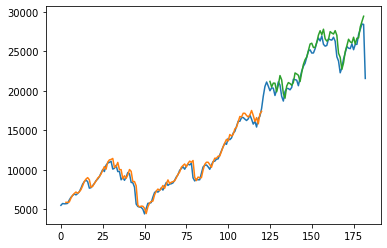

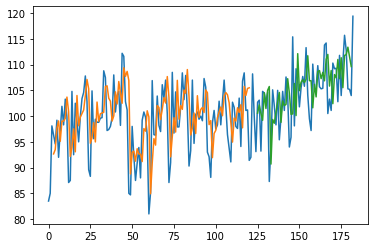

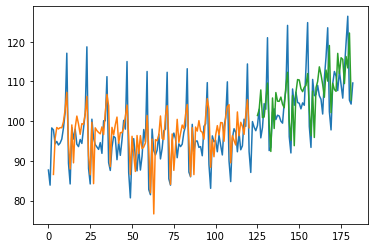

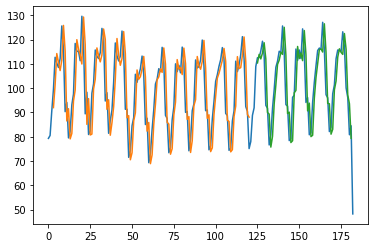

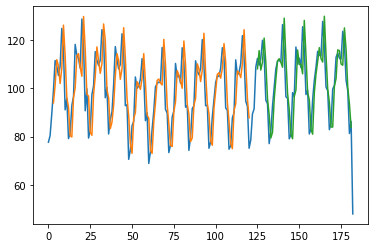

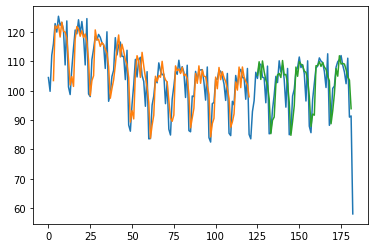

In [109]:
# Plot baseline and predictions
for i in range(dataset.shape[1]):
    plt.plot(dataset[:, i])
    plt.plot(trainPredictPlot[:, i])
    plt.plot(testPredictPlot[:, i])
    plt.show()

## Multilayer Perceptron using Window Methods

In [110]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictWindowPlot = np.empty_like(dataset)
trainPredictWindowPlot[:, :] = np.nan
testPredictWindowPlot = np.empty_like(dataset)
testPredictWindowPlot[:, :] = np.nan

for i in range(dataset.shape[1]):
    modelWindow = Sequential()
    modelWindow.add(Dense(12, input_dim=look_back, activation='relu'))
    modelWindow.add(Dense(8, activation='relu'))
    modelWindow.add(Dense(1))
    modelWindow.compile(loss='mean_squared_error', optimizer='adam')
    modelWindow.fit(trainX[i], trainY[i], epochs=400, batch_size=2, verbose=2)

    # Estimate model performance
    trainScore = modelWindow.evaluate(trainX[i], trainY[i], verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = modelWindow.evaluate(testX[i], testY[i], verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

    # Generate predictions for training
    trainPredict = modelWindow.predict(trainX[i])
    testPredict = modelWindow.predict(testX[i])

    # Shift train predictions for plotting
    trainPredictWindowPlot[look_back:len(trainPredict)+look_back, i] = trainPredict[:, 0]
    testPredictWindowPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, i] = testPredict[:, 0]

Streaming output truncated to the last 5000 lines.
 - 0s - loss: 119954.1698
Epoch 309/400
 - 0s - loss: 108498.4345
Epoch 310/400
 - 0s - loss: 107400.8245
Epoch 311/400
 - 0s - loss: 113970.5715
Epoch 312/400
 - 0s - loss: 111413.5822
Epoch 313/400
 - 0s - loss: 110569.8941
Epoch 314/400
 - 0s - loss: 112109.4985
Epoch 315/400
 - 0s - loss: 115529.9940
Epoch 316/400
 - 0s - loss: 119556.9283
Epoch 317/400
 - 0s - loss: 106799.1524
Epoch 318/400
 - 0s - loss: 116992.3305
Epoch 319/400
 - 0s - loss: 111175.4865
Epoch 320/400
 - 0s - loss: 112347.4776
Epoch 321/400
 - 0s - loss: 116030.1906
Epoch 322/400
 - 0s - loss: 110226.9683
Epoch 323/400
 - 0s - loss: 106364.3422
Epoch 324/400
 - 0s - loss: 109462.6727
Epoch 325/400
 - 0s - loss: 110662.5403
Epoch 326/400
 - 0s - loss: 113179.0814
Epoch 327/400
 - 0s - loss: 116012.1964
Epoch 328/400
 - 0s - loss: 116887.2373
Epoch 329/400
 - 0s - loss: 116731.9010
Epoch 330/400
 - 0s - loss: 106763.5933
Epoch 331/400
 - 0s - loss: 116191.5196
Epo

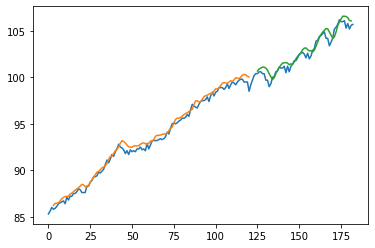

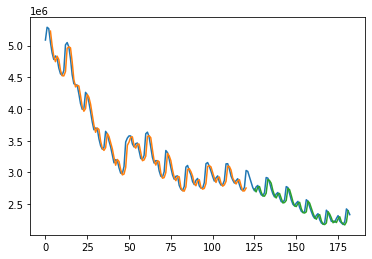

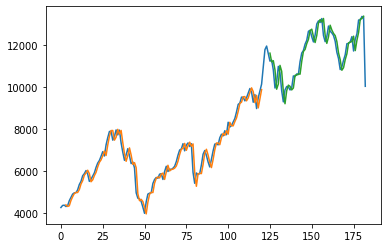

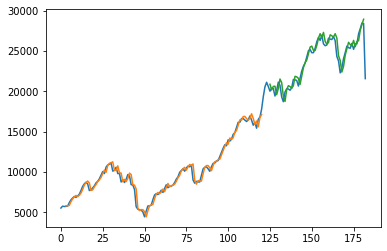

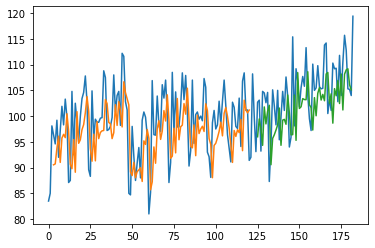

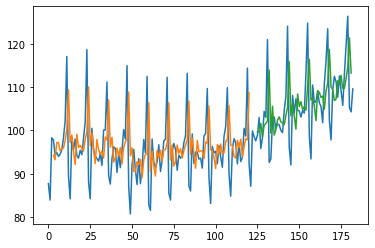

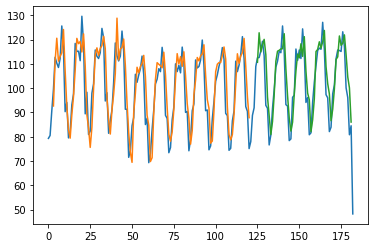

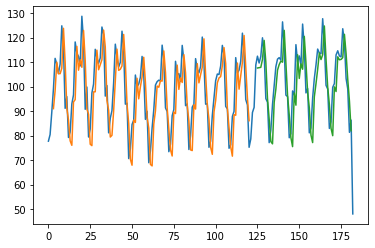

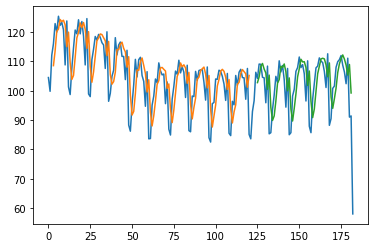

In [111]:
# Plot baseline and predictions
for i in range(dataset.shape[1]):
    plt.plot(dataset[:, i])
    plt.plot(trainPredictWindowPlot[:, i])
    plt.plot(testPredictWindowPlot[:, i])
    plt.show()

In [112]:
import pickle

# Save variables
with open('objs.pkl', 'wb') as f:
    pickle.dump([model, trainPredictPlot, testPredictPlot, 
                 modelWindow, trainPredictWindowPlot, testPredictWindowPlot], f)
    f.close()

# Getting back the objects:
with open('objs.pkl', 'rb') as f:
    model1, trainPlot1, testPlot1, model2, trainPlot2, testPlot2 = pickle.load(f)